<a href="https://colab.research.google.com/github/vitaliy-sharandin/data_science_projects/blob/master/portfolio/classification/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datasets
* https://www.kaggle.com/datasets/ealaxi/paysim1


#EDA

In [ ]:
!pip install -U -q datasets
!pip install -U -q ydata-profiling
!pip install -U -q feature_engine
!pip install -U -q optuna
!pip install -U -q boruta
!pip install -U -q eli5
!pip install -U -q scikit-plot

In [21]:
from datasets import load_dataset
from ydata_profiling import ProfileReport
import pandas as pd
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, fbeta_score
import optuna
from imblearn.over_sampling import SMOTE
from boruta import BorutaPy
import eli5
from sklearn.metrics import roc_auc_score, roc_curve
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import numpy as np
from scikitplot.estimators import plot_learning_curve

In [3]:
fraud_dataset = load_dataset("vitaliy-sharandin/synthetic-fraud-detection")
fraud_df = fraud_dataset['train'].to_pandas()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

As it was mentioned in dataset card, fraudulent transactions are being cancelled, hence fields below are not being updated with useful information to be useful for fraud detection.

In [4]:
fraud_df = fraud_df.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'])

In [5]:
# profile = ProfileReport(fraud_df, title="Fraud data report", dark_mode=True)
# profile.to_notebook_iframe()

Whole dataset analysis results
  * No missing values.
  * No feature is highly correlated with target.



In [6]:
# profile = ProfileReport(fraud_df[fraud_df['isFraud']==1], title="Fraudulent transactions report", dark_mode=True)
# profile.to_notebook_iframe()

Next, let's analyse the fraudulent transactions. Special attention needs to be given to 'isFlaggedFraud' feature. Let's analyse it closer.<br><br>
Q: Is isFlaggedFraud feature really appearing only for the transactions larger than 200000 in amount?<br>
A: Not true, they appear in other cases as well.

In [7]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(fraud_df.loc[fraud_df['isFlaggedFraud'] == 1]['type'].drop_duplicates())))


dfTransfer = fraud_df.loc[fraud_df['type'] == 'TRANSFER']
dfFlagged = fraud_df.loc[fraud_df['isFlaggedFraud'] == 1]
dfNotFlagged = fraud_df.loc[fraud_df['isFlaggedFraud'] == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged['amount'].min()))

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\n {}'.format(dfTransfer[dfTransfer['isFlaggedFraud'] == 0].amount.max()))


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set=
 92445516.64


Q: Can isFlaggedFraud be set based on seeing a customer transacting more than once?<br>
A: Since only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been destination accounts more than once,'isFlaggedFraud' being set is independent of whether a destination account has been used before or not.

In [8]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((fraud_df['nameOrig'].isin(pd.concat([fraud_df['nameOrig'], \
                                    fraud_df['nameDest']]))).any()))

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((fraud_df['nameDest'].isin(fraud_df['nameOrig'])).any()))

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(fraud_df['nameDest'].isin(fraud_df['nameDest']))))


Have originators of transactions flagged as fraud transacted more than once? True

Have destinations for transactions flagged as fraud initiated other transactions? True

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 6362620


It can be also seen that transactions with isFlaggedFraud set occur at all values of step, similar to the complementary set of transactions. Thus isFlaggedFraud does not correlate with step either and is therefore unrelated to any explanatory variable or feature in the data, hence it can be dropped.

In [9]:
fraud_df = fraud_df.drop(columns=['isFlaggedFraud'])

Such modifications leave us with following features: 'nameOrig', 'nameDest', 'type', 'step' and 'amount'. Let's see how useful they are for fraud detection.


# Feature engineering

In [23]:
def categorize_variables(target, df_train, cat_numeric_unique_threshold=10):
  target = target
  categorical_numeric = [var for var in df_train.columns if df_train[var].dtype!='O' and var!=target and df_train[var].nunique()<=cat_numeric_unique_threshold]
  continuous = [var for var in df_train.columns if df_train[var].dtype!='O' and var!=target and var not in categorical_numeric]
  mixed = [var for var in df_train.columns if pd.api.types.infer_dtype(df_train[var]) == 'mixed']
  categorical_object = [var for var in df_train.columns if df_train[var].dtype=='O' and var not in mixed]
  sorted_features = [target]+categorical_numeric+continuous+categorical_object+mixed
  print('Total columns: '+str(df_train.columns.size)+'\nColumns after sorting: '+str(len(sorted_features)))
  return target, categorical_numeric, continuous, mixed, categorical_object
target, categorical_numeric, continuous, mixed, categorical_object = categorize_variables('isFraud', fraud_df)

Total columns: 6
Columns after sorting: 6


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fraud_df[fraud_df.columns.difference([target])], fraud_df[target], test_size=0.2, stratify=fraud_df[target], random_state=42)

In [42]:
encoder = OrdinalEncoder(
    variables=categorical_object,
    encoding_method='ordered'
)

X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.fit_transform(X_test, y_test)

In [14]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)

# Model testing

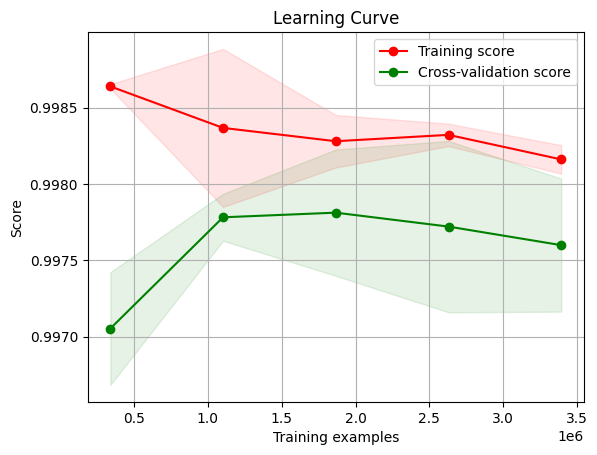

Weight,Feature
0.7145,nameOrig
0.2288,nameDest
0.0428,type
0.0082,amount
0.0057,step


Explanation(estimator="XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.7, device=None, early_stopping_rounds=None,\n              enable_categorical=False, eta=0.1, eval_metric='logloss',\n              feature_types=None, gamma=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,\n              max_leaves=None, min_child_weight=None, missing=nan,\n              monotone_constraints=None, multi_strategy=None, n_estimators=None,\n              n_jobs=None, num_parallel_tree=None, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=7.886125553228288, std=None, value=1.0), FeatureWeight(feature='nameOrig', weight=1.268981458117019, std=None, value=1271238.0), FeatureWeight(feature='nameDest', weight=0.804419506084675, std=None, value=776774.0)], neg=[FeatureWeight(feature='step', weight=-0.41587437420616713, std=None, value=583.0), FeatureWeight(feature='amount', weight=-0.30828745728771584, std=None, value=759701.03), FeatureWeight(feature='type', weight=-0.21767568643610083, std=None, value=3.0)], pos_remaining=0, neg_remaining=0), proba=0.9999835, score=-9.017688999499997, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

ROC AUC score: 0.9507566399214883


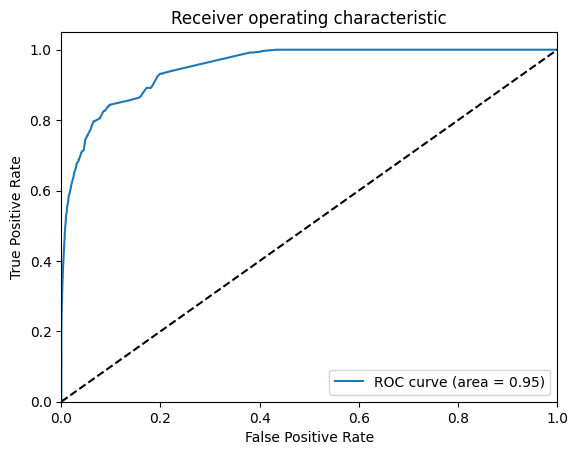

CPU times: user 6min 20s, sys: 3.77 s, total: 6min 24s
Wall time: 4min 2s


In [43]:
%%time
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'tree_method': 'hist'
}
model = XGBClassifier(**params)

# Plot the learning curve for cross validation
f2_scorer = make_scorer(fbeta_score, beta=2, zero_division=1)

plot_learning_curve(model, X_train, y_train, cv=3, scoring=f2_scorer)
plt.show()



# ELI5 feature importances for model
model.fit(X_train, y_train)

display(eli5.show_weights(model, feature_names = X_test.columns.tolist()))



# Make predictions for test data
y_pred = model.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_pred)
print('ROC AUC score:', roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**Results** <br>
**Learning curve** indicates that our training curve has constant score of 1, indicating perfect prediction of training data. The validation curve quickly converges with training curve, meaning that model achieves high generalization which at the first glance seems good.<br>

Yet everything changes when we look at **eli5 feature importances**. They indicate that only origin name feature is of great importance for a model.<br>

What's interesting, predictions on test data give us a good f2 score.

**Final conclusions**<br>
This means that we can predict whether a transaction is fraud or not by only looking at the originator of transaction. Such model wouldn't be able to detect frauds in real world scenarios where attackers will definitely target multiple originators. Therefore I question whether this training dataset reflects reality and has usefulness.